In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(  # is a convenient way to load image data from a directory structure into a TensorFlow dataset.
    "PlantVillage", #directory name
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1712 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

54

In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())#to convert tensor object to numpy array

(32, 256, 256, 3)
[0 1 2 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0]


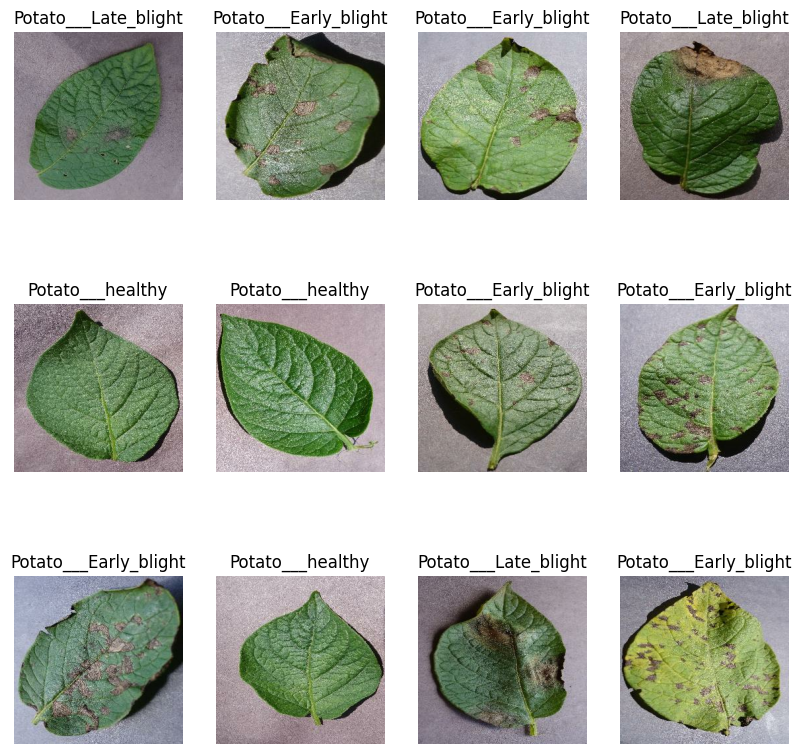

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
      ax = plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))#convert to numpy:This is necessary because Matplotlib (plt.imshow) works with NumPy arrays.; astype: unsigned 8-bit integers, values between 0 and 255).
      plt.axis("off")
      plt.title(class_names[label_batch[i]])

In [9]:
#80%---> training 20%--->10%validation 10% test
#validation set will be used for each epoch while test data will be used for once at the end when model is fully trained
train_size=0.8
len(dataset)*train_size

43.2

In [10]:
train_ds=dataset.take(43)

In [11]:
test_ds=dataset.skip(43)

In [12]:
val_size=0.1
len(dataset)*val_size

5.4

In [13]:
val_ds=test_ds.take(5)

In [14]:
test_ds=test_ds.skip(5)
len(test_ds)

6

In [15]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)#shuffling before the train test split
    #shuffle_size:Determines the size of the buffer used for shuffling.TensorFlow maintains a buffer of shuffle_size elements and randomly samples elements from this buffer during shuffling.
    #seed: If you shuffle data with a seed, the shuffle order will always be the same, no matter how many times you run the code
    
    train_size=int(ds_size*train_split)
    val_size = int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

43

In [18]:
len(val_ds)

5

In [19]:
len(test_ds)

6

In [20]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale =  tf.keras.Sequential([#tf.keras.Sequential is a simple way to build a model or a pipeline in TensorFlow's Keras API. It allows you to stack layers (or preprocessing steps) in a sequential order, where the output of one layer is directly passed as input to the next.
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)#Scales pixel values from the range [0, 255] to [0, 1].
])# this layer will go to the ultimate model and when we have trained model and whenit starts predicting; and during predication if we are supplying an image which is not 256*256 this will take care of resizeing   

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),#Randomly flips the images both horizontally (left-right) and vertically (up-down).This ensures the model learns to recognize features regardless of the image's orientation.

    layers.RandomRotation(0.2),#Randomly rotates the images by up to 20% of a full circle (360°), which is equivalent to 0.2×360°=72°.This helps the model learn to recognize objects even if they are slightly rotated in the input data.
])

In [23]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu'), #Detect features in the image like edges, textures, or patterns; all 32 , 64 values are based on trial and error depending on when model performs well
    #32 indicates no of filters in that layer; Each layer uses filters (kernels) of size 3*3 to extract features; activation='relu' introduces non-linearity, making the model capable of learning complex patterns.
    layers.MaxPooling2D((2,2)),#A  2×2 pooling window downsamples the data by taking the maximum value from a region, reducing computation and preventing overfitting; reducing the size of the image while preserving the imp feature. 
    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),#Converts the 2D feature maps into a 1D vector so it can be fed into the final dense (fully connected) layers for classification.
    layers.Dense(64, activation = 'relu'),#64 neurons;After convolutional and pooling layers extract features (like edges or patterns), the dense layer combines these features to recognize higher-level structures or relationships;Example: Combining "eyes," "nose," and "mouth" features to recognize a "face."
    layers.Dense(n_classes, activation = 'softmax'),#Dense layers act as a transition from feature extraction (convolutions) to output (classification or regression).
])

In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(#all this explained in presentation slide
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history=model.fit(#training the model
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)
    

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 898ms/step - accuracy: 0.5399 - loss: 0.9263 - val_accuracy: 0.6062 - val_loss: 0.8097
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 852ms/step - accuracy: 0.6177 - loss: 0.7379 - val_accuracy: 0.7375 - val_loss: 0.5999
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 856ms/step - accuracy: 0.7435 - loss: 0.5831 - val_accuracy: 0.7375 - val_loss: 0.6059
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 880ms/step - accuracy: 0.7946 - loss: 0.4888 - val_accuracy: 0.7312 - val_loss: 0.5633
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 847ms/step - accuracy: 0.8714 - loss: 0.3332 - val_accuracy: 0.8438 - val_loss: 0.3414
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 884ms/step - accuracy: 0.9084 - loss: 0.2384 - val_accuracy: 0.8438 - val_loss: 0.4210
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 827ms/step - accuracy: 0.8806 - loss: 0.3272 - val_accuracy: 0.7937 - val_loss: 0.4953
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 891ms/step - accuracy: 0.9044 - loss: 0.2503 - val_accu

In [29]:
scores = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.9331 - loss: 0.1870


In [30]:
scores

[0.19332486391067505, 0.9270833134651184]

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 43}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss=history.history['val_loss']

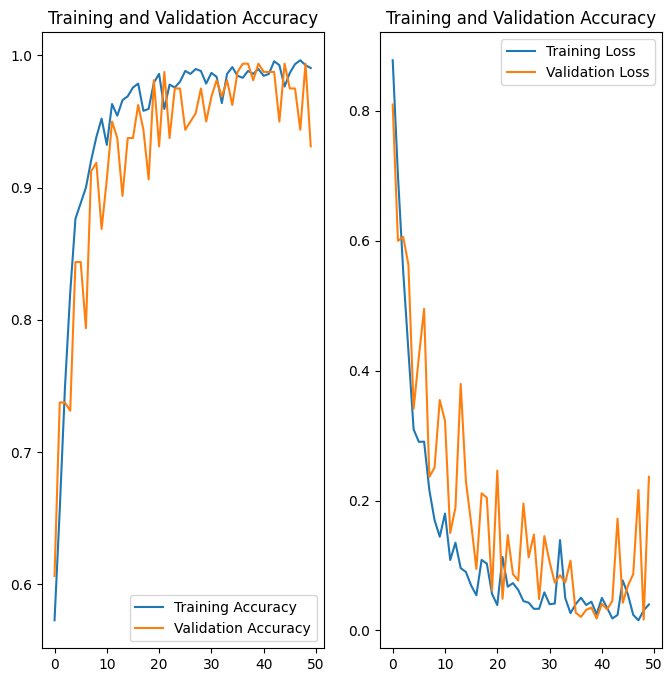

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)#Creates a subplot in a grid with 1 row and 2 columns.; Activates the first subplot in this grid for plotting.
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)#Creates a subplot in a grid with 1 row and 2 columns.; Activates the second subplot in this grid for plotting.
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

first image to predict
first image's actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
predicted label: Potato___Late_blight


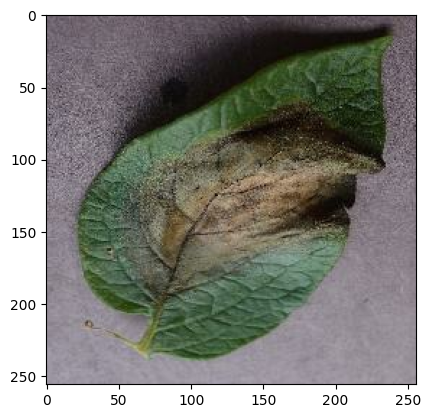

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [36]:
def predict(model,img):#model: A trained machine learning model that will make predictions.img: The image you want to predict the class for.
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())#converts the image into a numpy array; .numpy() is used to convert a TensorFlow tensor into a numpy array.
    img_array = tf.expand_dims(img_array,0)#create a batch;
    #Models expect input as a batch of images. So, even if you're predicting a single image, we add an extra dimension (the batch dimension), converting the image shape from (height, width, channels) to (1, height, width, channels).
    predictions = model.predict(img_array)#returns an array of predicted values (probabilities for each class).
    predicted_class = class_names[np.argmax(predictions[0])]#batch of size 1; This is a 2D array with the probabilities for the 3 classes for the single image in the batch
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


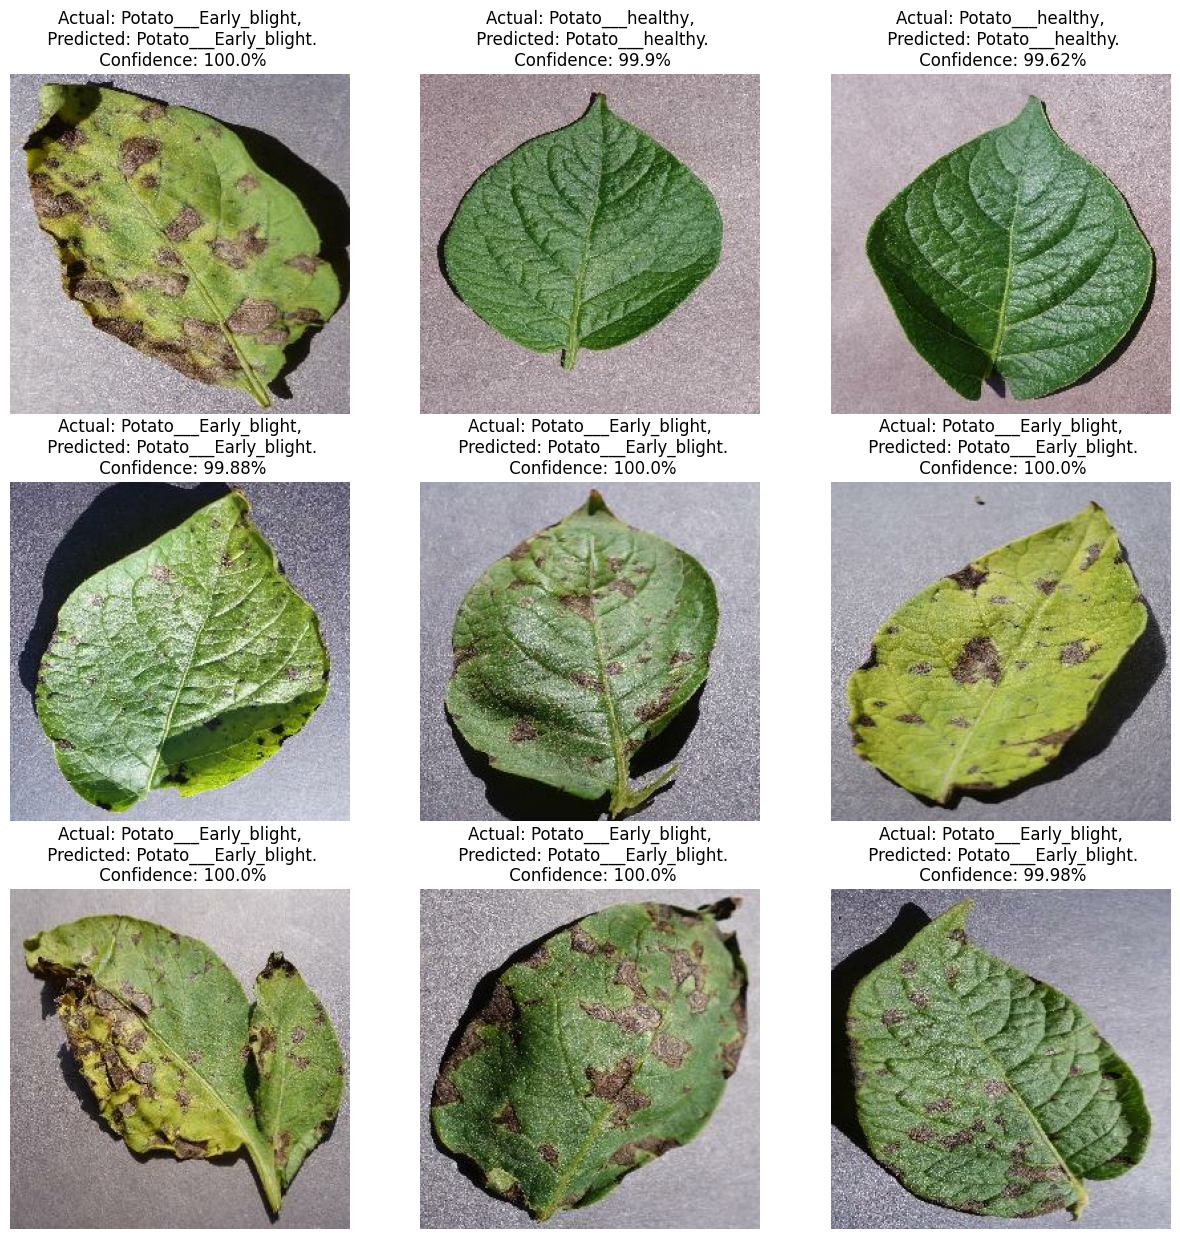

In [37]:

plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model,images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [41]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1#os.listdir("../models"): This returns a list of all the files and folders inside the ../models/ directory.
#[int(i) for i in os.listdir("../models")]: This converts the directory listing (which is a list of strings) into a list of integers
#+ [0]: Adds a 0 to the list to ensure that the max() function works even if the directory is empty or doesn't contain numeric folders.
#max(...): Finds the maximum integer from the list of existing versions.
#+ 1: Increments the maximum version by 1 to create the new version for the next model.
model.export(f"../saved_models/{model_version}")
#we have created these models bcz once you created this modeland next time you will create another model with some changes , remode augmentation etc that can be saved in some other model versions 

INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets


Saved artifact at '../saved_models/3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2675498309328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2675498309520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2675498312016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2675498312208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2675498312400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2675498314704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2675498314320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2675498315088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2675498314512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2675498315472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2675498315280: TensorSpec(shape=(

In [42]:
# import os
# existing_versions = [int(i.split('.')[0]) for i in os.listdir("../saved_models") if i.endswith('.keras') or i.endswith('.h5')]

# # Determine the next model version
# if existing_versions:
#     model_version = max(existing_versions) + 1
# else:
#     model_version = 1

# model.save(f"../saved_models/{model_version}.h5")